In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,\
GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, f1_score

Pipelearn imblearn supaya bisa fit resample.

Pipelaen sklearn hanya bisa fit transform, ga mengenal fit resample.

### Balancing Method with Cross Validation

In [2]:
bankloan = pd.read_csv('bankloan.csv')
bankloan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


In [50]:
x = bankloan[['employ', 'debtinc', 'creddebt', 'othdebt']]
y = bankloan['default']

### Data Splitting

In [51]:
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y,
    stratify=y,
    test_size=0.2,
    random_state=1899
)

### Resampling: SMOTE
- Masih bisa di-improve lagi

In [52]:
smote = SMOTE(random_state=1899)
model = LogisticRegression()

estimator = Pipeline([
    ('balancing', smote),
    ('model', model)
])

In [53]:
skfold = StratifiedKFold(n_splits=5)
model_cv = cross_val_score(
    estimator, X_train_val, y_train_val, 
    cv=skfold, scoring='f1')

In [54]:
print('CV Score: {}'.format(model_cv))
print('CV Score Mean: {}'.format(model_cv.mean()))

CV Score: [0.55       0.61111111 0.61764706 0.74193548 0.52173913]
CV Score Mean: 0.6084865568480782


### Algo Based: Penalised

In [55]:
model = LogisticRegression(class_weight='balanced')
skfold = StratifiedKFold(n_splits=5)
model_cv = cross_val_score(
    model, x_train_val, y_train_val, 
    cv=skfold, scoring='f1')

In [56]:
print('CV Score: {}'.format(model_cv))
print('CV Score Mean: {}'.format(model_cv.mean()))

CV Score: [0.56097561 0.60273973 0.60869565 0.76190476 0.52173913]
CV Score Mean: 0.6112109760593905


From cross validation result, the better model is penalized!

### Combining Balancing Method with Hyperparameter Tuning

In [57]:
smote = SMOTE(random_state=1899)
model = LogisticRegression()
estimator = Pipeline([
    ('balancing', smote),
    ('model', model)
])

In [58]:
hyperparam_space = {
    'balancing__k_neighbors': [2, 5, 10, 15, 20],
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'model__solver':['liblinear', 'newton-cg']
}

skfold = StratifiedKFold(n_splits=5)

In [59]:
grid_search = GridSearchCV(
    estimator, 
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [60]:
grid_search.fit(x_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancing', SMOTE(random_state=1899)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'balancing__k_neighbors': [2, 5, 10, 15, 20],
                         'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'model__solver': ['liblinear', 'newton-cg']},
             scoring='f1')

In [61]:
print('Best score: {}'.format(grid_search.best_score_))
print('Best param: {}'.format(grid_search.best_params_))

Best score: 0.6253317990026852
Best param: {'balancing__k_neighbors': 10, 'model__C': 0.01, 'model__solver': 'newton-cg'}


### Before tuning

In [62]:
smote = SMOTE(random_state=1899)
model = LogisticRegression()
estimator = Pipeline([
    ('balancing', smote),
    ('model', model)
])

In [63]:
estimator.fit(x_train_val, y_train_val)
y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.72      0.81       103
           1       0.52      0.86      0.65        37

    accuracy                           0.76       140
   macro avg       0.73      0.79      0.73       140
weighted avg       0.83      0.76      0.77       140



### After tuning

In [64]:
grid_search.best_estimator_.fit(x_train_val, y_train_val)
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       103
           1       0.52      0.84      0.64        37

    accuracy                           0.75       140
   macro avg       0.72      0.78      0.72       140
weighted avg       0.82      0.75      0.76       140



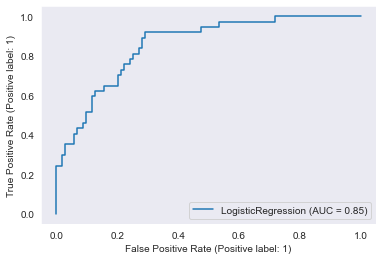

In [65]:
sns.set_style("dark")
plot_roc_curve(model, x_test, y_test)

# Exercise

- Masih menggunakkan bankloan dan fitur yang sama
    - Coba bandingkan performa berbagai macam model dan metode balancing
    - Carilah model dengan performa terbaik. Jangan lupa untuk mengimprove model dengan hyperparameter tuning

In [42]:
models = [
    ['Log Regression', LogisticRegression(max_iter=10000)], 
    ['Decision Tree', DecisionTreeClassifier(max_depth=3, random_state=2020)], 
    ['K Neighbors', KNeighborsClassifier(n_neighbors=2)]
]

In [66]:
def evaluate(models, scoring):
    return pd.DataFrame({'Models': [name for name, model in models], 
                         'Cross Validation Score': [cross_val_score(model, x_train_val, y_train_val, scoring=scoring, cv=StratifiedKFold(n_splits=5)).mean() 
              for name, model in models],
                         'Standard Deviations': [cross_val_score(model, x_train_val, y_train_val, scoring=scoring, cv=StratifiedKFold(n_splits=5)).std()
          for name, model in models]
                        })

In [67]:
evaluate(models, 'f1')

,Models,Cross Validation Score,Standard Deviations
0,Log Regression,0.563146,0.087313
1,Decision Tree,0.524517,0.052215
2,K Neighbors,0.333881,0.126996


### Balancing SMOTE and NearMiss

In [70]:
smote = SMOTE(random_state=1899)
nearmiss = NearMiss()

In [71]:
def balancing(models,balancing,scoring):

    model_name=[]
    scores=[]
    score_std=[]
    for name, model in models:
        model = model
        estimator = Pipeline([
            ('balancing', balancing),
            ('model', model)])

        skfold=StratifiedKFold(n_splits=5)
        score= cross_val_score(estimator,x_train_val,y_train_val,scoring=scoring,cv=skfold).mean()
        std= cross_val_score(estimator,x_train_val,y_train_val,scoring=scoring,cv=skfold).std()
        scores.append(score)
        score_std.append(std)
        model_name.append(name)

    return pd.DataFrame({'Name': model_name,'score':scores, 'score_std':score_std})

In [72]:
balancing(models, smote,'f1')

,Name,score,score_std
0,Log Regression,0.608487,0.075954
1,Decision Tree,0.526947,0.031656
2,K Neighbors,0.406898,0.112780


In [73]:
balancing(models, nearmiss,'f1')

,Name,score,score_std
0,Log Regression,0.519578,0.038338
1,Decision Tree,0.486989,0.037343
2,K Neighbors,0.396859,0.049293


### Algo Based: Penalized

In [74]:
algo = [
    ['Log Regression', LogisticRegression(class_weight='balanced')],
    ['DecisionTree', DecisionTreeClassifier(max_depth=3,random_state=2020, class_weight='balanced')]]

In [75]:
evaluate(algo,'f1')

,Models,Cross Validation Score,Standard Deviations
0,Log Regression,0.611211,0.081628
1,DecisionTree,0.533400,0.046114


Berdasarkan mean dan std, model terbaik adalah log regression dengan smote. Namun, karena sudah dicoba diatas, kali ini kita gunakan model dengan mean dna std kedua terbaik yaitu decision tree dengan smote.

### Combining Balancing Method with Hyperparameter Tuning

In [77]:
tree = DecisionTreeClassifier(max_depth=3, random_state=2020)
smote = SMOTE(random_state=1899)
estimator = Pipeline([
    ('balancing',smote), 
    ('model', tree)
])

In [82]:
hyperparam_space = {
    'balancing__k_neighbors': [2,5,10,15,20],
    'model__max_depth': [2,3,4,5,6,7,8,9,10],
    'model__min_samples_leaf':[1,5,10,20,50,100],
    'model__min_samples_split':[1,5,10,20,50,100],
    'model__criterion': ['gini', 'entropy']
}

In [83]:
skfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [84]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'balancing', 'model', 'balancing__k_neighbors', 'balancing__n_jobs', 'balancing__random_state', 'balancing__sampling_strategy', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__random_state', 'model__splitter'])

In [85]:
grid_search.fit(x_train_val, y_train_val)

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.54378441 0.54378441 ... 0.53923125 0.53923125 0.53923125]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('balancing', SMOTE(random_state=1899)),
                                       ('model',
                                        DecisionTreeClassifier(max_depth=3,
                                                               random_state=2020))]),
             n_jobs=-1,
             param_grid={'balancing__k_neighbors': [2, 5, 10, 15, 20],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 5, 10, 20, 50, 100],
                         'model__min_samples_split': [1, 5, 10, 20, 50, 100]},
             scoring='f1')

In [86]:
print('Best score: {}'.format(grid_search.best_score_))
print('Best param: {}'.format(grid_search.best_params_))

Best score: 0.571532673539133
Best param: {'balancing__k_neighbors': 5, 'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 100, 'model__min_samples_split': 5}


### Before tuning

In [87]:
smote = SMOTE(random_state=1899)
model = DecisionTreeClassifier(max_depth=3, random_state = 2020)
estimator = Pipeline([
    ('balancing', smote),
    ('model', model)
])

In [88]:
estimator.fit(x_train_val, y_train_val)
y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.53      0.68       103
           1       0.41      0.89      0.56        37

    accuracy                           0.63       140
   macro avg       0.67      0.71      0.62       140
weighted avg       0.79      0.63      0.65       140



### After tuning

In [89]:
grid_search.best_estimator_.fit(x_train_val, y_train_val)
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.64      0.72       103
           1       0.38      0.62      0.47        37

    accuracy                           0.64       140
   macro avg       0.60      0.63      0.60       140
weighted avg       0.71      0.64      0.66       140



Sebelum tuning, nilai f1 score 0.56, sesudah tuning nilai f1 score 0.47. F1 score turun drastis setelah hyperparameter tuning